# Import

In [1]:
import os
import sys
from pathlib import Path

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace
from PIL import Image

In [2]:
sys.path.append('../../')

In [3]:
from style_transfer.data import *
from style_transfer.models import *

# Config

In [4]:
dir_data = Path('../../data')

# Utility

In [5]:
def save_checkpoint(model, optimizer, metrics, file_checkpoint):
    file_checkpoint.parent.mkdir(exist_ok=True)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'metrics': metrics},
               file_checkpoint)

In [6]:
def load_checkpoint(model, optimizer, file_checkpoint):
    checkpoint = torch.load(file_checkpoint)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    metrics = checkpoint['metrics']
    return model, optimizer, metrics

In [7]:
def epoch(model, dl, loss, optimizer, device, mode):
    metrics_e, total_e = dict.fromkeys(loss.get_metric_names(), 0), 0
    model.train() if mode == 'trn' else model.eval()
    with torch.set_grad_enabled(mode == 'trn'):
        for X, y in dl:
            X, y = X.to(device), y.to(device)

            # Get loss and batch metrics
            if mode == 'trn': optimizer.zero_grad()            
            y_hat = model(X)
            l, metrics_b = loss(y_hat, y)            
            if mode == 'trn': l.backward(), optimizer.step()

            # Scale metrics
            for key in metrics_e.keys(): metrics_e[key] += metrics_b[key]*X.shape[0]
            total_e += X.shape[0] # Track total number of items in epoch

    # Get mean of metrics
    for key in metrics_e.keys(): metrics_e[key] /= total_e
    return metrics_e

# Train

In [8]:
# Config
batch_size = 4
num_workers = 4
pin_memory = True
num_epochs = 20
lr = 1e-3
sz = 256
dir_styl = dir_data/'style'
dir_cont = dir_data/'content'
num_samples = 10000

# Device
device = torch.device('cuda')

# Loss
loss = FeatureLoss(models.vgg16(pretrained=True).features, 
                   dir_styl/'hiroshige_winter.jpg', 
                   sz, 
                   [0,1,2,3], 
                   [1],
                   [1e10, 1e10, 1e10, 1e10],
                   [1e5])

# Checkpoint metric name
name_checkpoint = 'l'

# Model
in_channels  = 3
layout_encoder = [[[ 32,7]],
                  [[ 64,3], [ 64,3]],
                  [[128,3], [128,3], [128,3], [128,3], [128,3], [128,3], [128,3], [128,3]]]
model = AutoEncoder(get_encoder(in_channels, layout_encoder), k_l=7)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
tfms_trn = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225])])

dl_trn = SubsetDataloader(ImgCSVDataset(dir_cont/f'formatted_{sz}', dir_cont/'trn.csv', tfms=tfms_trn), 
                          batch_size=batch_size,
                          num_workers=num_workers,
                          pin_memory=pin_memory,
                          num_samples=num_samples)

In [10]:
tfms_val = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225])])

dl_val = data.DataLoader(ImgCSVDataset(dir_cont/f'formatted_{sz}', dir_cont/'val.csv', tfms=tfms_val), 
                         batch_size=batch_size,
                         num_workers=num_workers,
                         pin_memory=pin_memory) # Dont subsample validation set

<IPython.core.display.Javascript object>


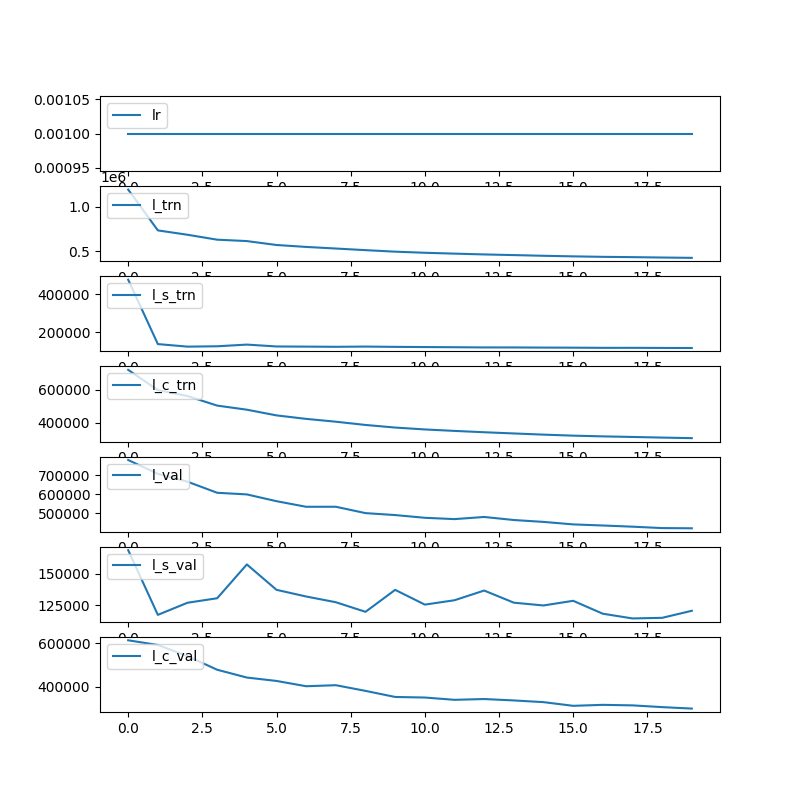

          lr    l_trn  l_s_trn  l_c_trn    l_val  l_s_val  l_c_val
0          0  1194557   476565   717992   781502   168937   612565  475 s - l reduced; cping...
1          0   735802   139228   596574   708343   117200   591144  484 s - l reduced; cping...
2          0   686746   125875   560871   666821   126892   539929  469 s - l reduced; cping...
3          0   631439   127722   503718   608268   130483   477785  460 s - l reduced; cping...
4          0   615720   136542   479178   599601   157510   442091  459 s - l reduced; cping...
5          0   571703   126751   444952   563778   137215   426563  459 s - l reduced; cping...
6          0   550031   125952   424080   534232   131869   402364  459 s - l reduced; cping...
7          0   532060   124979   407081   534362   127294   407068  459 s
8          0   513822   126151   387671   500714   119629   381085  459 s - l reduced; cping...
9          0   496741   124665   372076   490422   137188   353234  459 s - l reduced; cpin

In [11]:
%matplotlib notebook

# Training loop
df_metrics = pd.DataFrame()
metric_checkpoint = np.inf # Initialize to arbitrarily high value
fig, axs = plt.subplots(1+2*len(loss.get_metric_names()), 1, figsize=(8,8))
for num_epoch in range(num_epochs):
    start = time.time()
    
    # Train
    metrics_trn = epoch(model, dl_trn, loss, optimizer, device, 'trn')
    
    # Validate
    metrics_val = epoch(model, dl_val, loss, optimizer, device, 'val')
    
    # Store metrics
    df_metrics.loc[num_epoch, 'lr'] = np.mean([p['lr'] for p in optimizer.param_groups])
    for key, val in metrics_trn.items(): df_metrics.loc[num_epoch, key+'_trn'] = val
    for key, val in metrics_val.items(): df_metrics.loc[num_epoch, key+'_val'] = val
    
    # Print metrics
    print(df_metrics.iloc[[num_epoch]].to_string(header=num_epoch == 0,
                                                 float_format=lambda x: f'{x:8.0f}',
                                                 col_space=3), end='')
    
    end = time.time(); print(f'{end - start:5.0f} s', end='')

    # Checkpoint best
    if metrics_val[name_checkpoint] < metric_checkpoint:
        print(f' - {name_checkpoint} reduced; cping...', end='')
        save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/best.pth'))
        metric_checkpoint = metrics_val[name_checkpoint]
        
    # Checkpoint last
    save_checkpoint(model, optimizer, df_metrics, Path('checkpoints/last.pth'))
        
    # Print newline
    print()
    
    # Plot stuff
    for idx, key in enumerate(df_metrics.columns):
        axs[idx].clear()
        axs[idx].plot(np.arange(num_epoch+1), df_metrics[key], label=key)
        axs[idx].legend(loc='upper left')
    fig.canvas.draw()
    
%matplotlib inline

# Test

In [12]:
model, _, _ = load_checkpoint(model, optimizer, 'checkpoints/best.pth')

Inspect training dataset

In [81]:
X, y = next(iter(dl_trn))
X, y = X.to(device), y.to(device)

In [82]:
model.eval()
with torch.no_grad():
    y_hat = model(X)

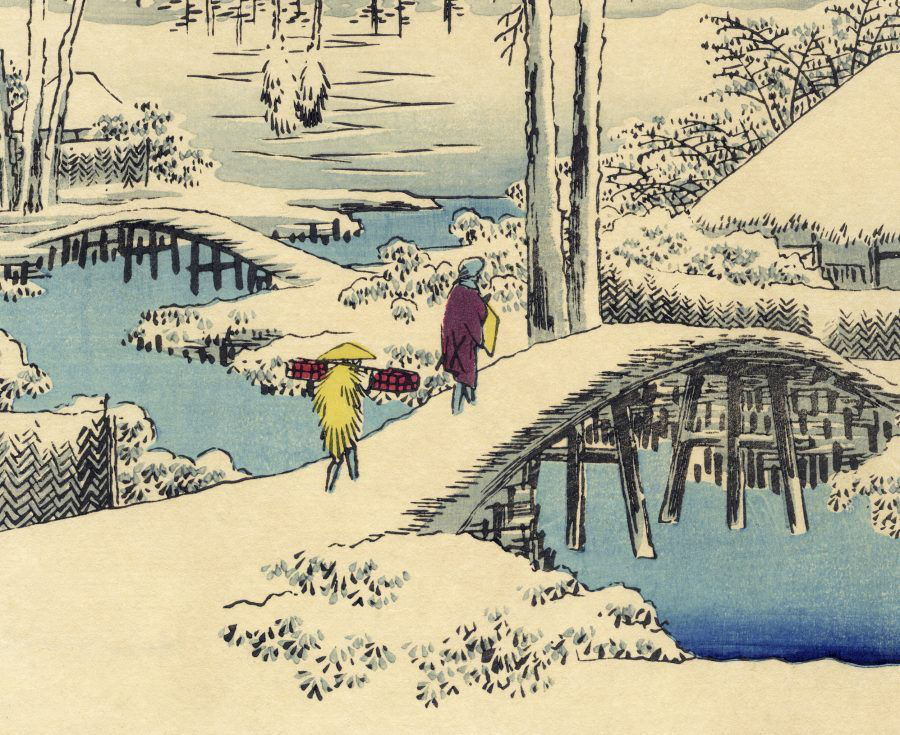

In [29]:
Image.open(dir_styl/'hiroshige_winter.jpg')

In [86]:
idx = 1

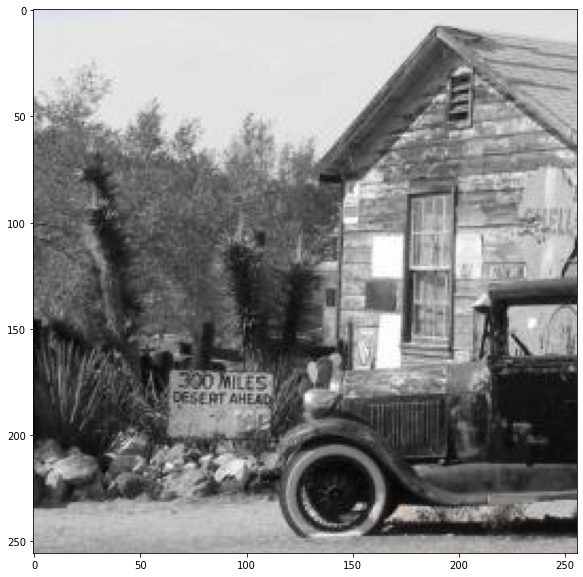

In [87]:
plt.figure(figsize=(15,10))
img = torch2np(X[idx])
plt.imshow(denorm(img))

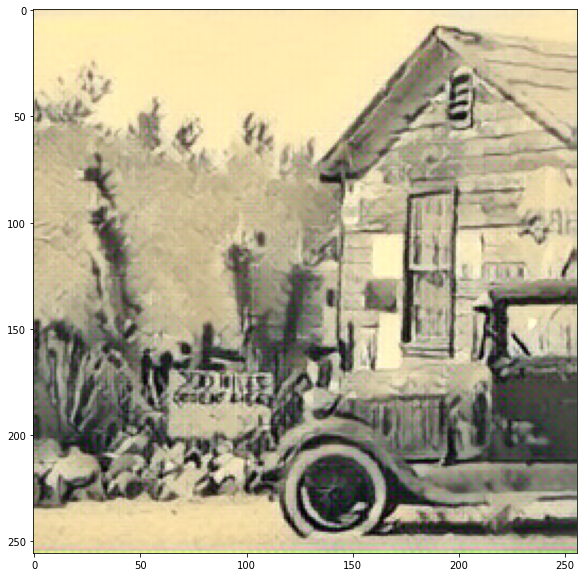

In [88]:
plt.figure(figsize=(15,10))
img = torch2np(y_hat[idx])
plt.imshow(denorm(img))